<a href="https://colab.research.google.com/github/DCollins23/SEC_Demos/blob/main/pytorch_sec_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Showing off PyTorch

In [ ]:
x = torch.arange(1, 10)
x

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
y = 2 * x + 1
y

tensor([ 3,  5,  7,  9, 11, 13, 15, 17, 19])

In [ ]:
z = (x % 2 == 0)
z

tensor([False,  True, False,  True, False,  True, False,  True, False])

In [ ]:
x = torch.arange(1, 7).reshape(2, 3)
x = x.float()
print(x.shape)
x

torch.Size([2, 3])


tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
x.mean(dim=0)

tensor([2.5000, 3.5000, 4.5000])

In [ ]:
x.sum(dim=1, keepdim=True)

tensor([[ 6.],
        [15.]])

> Talk about broadcasting and dimensions

# Model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
x_train = torch.from_numpy(x_train).float() / 255
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float() / 255
y_test = torch.from_numpy(y_test).long()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def plot_img(img_tens):
  plt.imshow(img_tens.reshape(28, 28));

tensor(5)


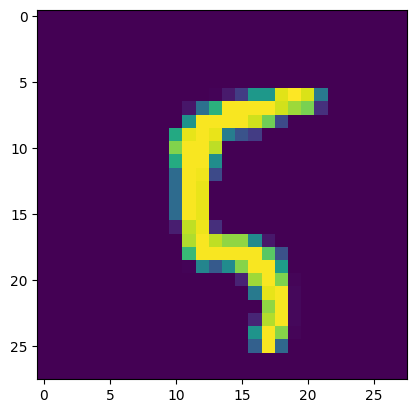

In [ ]:
i = 100
plot_img(x_train[i])
print(y_train[i])

In [ ]:
# declare model
class BasicModel(torch.nn.Module):

  def __init__(self):
    super(BasicModel, self).__init__()
    n_in = 784
    n_hidden1 = 1_000
    n_out = 10

    self.layers = nn.Sequential(
      nn.Linear(n_in, n_hidden1),
      nn.ReLU(),
      nn.Linear(n_hidden1, n_out),
    )

  def forward(self, x):
    return self.layers(x)

In [ ]:
model = BasicModel()
logits = model(x_train[0])
logits

tensor([ 0.0741, -0.0300, -0.0546, -0.0871, -0.0612,  0.0043, -0.0921, -0.0366,
        -0.1191,  0.1342], grad_fn=<ViewBackward0>)

In [ ]:
[print(p.shape) for p in model.parameters()]

torch.Size([1000, 784])
torch.Size([1000])
torch.Size([10, 1000])
torch.Size([10])


[None, None, None, None]

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

795010

In [ ]:
max_iter = 10
model = BasicModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
for i in range(max_iter):
  optimizer.zero_grad()
  logits = model(x_train)
  loss = F.cross_entropy(logits, y_train)
  loss.backward()
  optimizer.step()
  print(i, loss.item())

0 2.302894115447998
1 2.015059471130371
2 1.706375241279602
3 1.359289288520813
4 1.0979764461517334
5 1.4082834720611572
6 3.230609655380249
7 1.9747523069381714
8 1.666353464126587
9 1.343738079071045
10 1.065885066986084
11 0.9022490978240967
12 1.0604368448257446
13 1.6178245544433594
14 1.5868449211120605
15 1.3101717233657837
16 0.9920015335083008
17 0.7220316529273987
18 0.6351795196533203
19 0.6763202548027039


In [ ]:
# once cuda is done
x_train = x_train.to(dev)
y_train = y_train.to(dev)
x_test = x_test.to(dev)
y_test = y_test.to(dev)

time: 60.2 ms (started: 2024-03-20 23:30:55 +00:00)


In [ ]:
train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train), batch_size=32, shuffle=True)

In [ ]:
# batching
model = BasicModel()
optimizer = torch.optim.SGD(model.parameters(), lr=1)
max_epochs = 10
all_losses = []
mean_losses = []
for i in range(max_epochs):
  epoch_losses = []
  for x_b, y_b in train_loader:
    # get output
    logits = model(x_b)
    # calculate loss
    loss = F.cross_entropy(logits, y_b)
    # reset gradients
    optimizer.zero_grad()
    # calculate new gradients
    loss.backward()
    # adjust parameters
    optimizer.step()
    epoch_losses.append(loss.item())
    all_losses.append(loss.item())
  mean_loss = torch.tensor(epoch_losses).mean()
  print(i, mean_loss)
  mean_losses.append(mean_loss.item())
all_losses = torch.tensor(all_losses)

0 tensor(0.2830)
1 tensor(0.1300)
2 tensor(0.1008)
3 tensor(0.0822)
4 tensor(0.0678)
5 tensor(0.0593)
6 tensor(0.0609)
7 tensor(0.0434)
8 tensor(0.0456)
9 tensor(0.0367)


In [ ]:
def calc_accuracy(images, labels):
  logits = model(images)
  # probs = F.softmax(logits, dim=1)
  pred = torch.argmax(logits, dim=1)
  correct = torch.sum(pred == labels)
  total = images.shape[0]
  acc = correct / total
  return acc

In [ ]:
calc_accuracy(x_train, y_train)

tensor(0.9895)

In [ ]:
calc_accuracy(x_test, y_test)

tensor(0.9744)

# Cuda

In [ ]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
dev

device(type='cuda')

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.4 MB/s eta 0:00:00
time: 253 µs (started: 2024-03-20 23:30:36 +00:00)


In [ ]:
tens1 = torch.randn(10000, 10000).to(dev)
tens2 = torch.randn(10000, 10000).to(dev)

time: 1.97 s (started: 2024-03-20 23:35:46 +00:00)


In [ ]:
tens1.device

device(type='cuda', index=0)

time: 2.26 ms (started: 2024-03-20 23:35:50 +00:00)


In [ ]:
tens1 @ tens2

tensor([[-103.1879,  124.3162,   86.5212,  ...,   21.7266,  112.2694,
           76.0319],
        [  65.9042,   83.5997,  -14.8248,  ..., -117.4686,  -45.1416,
         -168.5793],
        [ -63.3832,    9.2017,   13.8751,  ...,  113.7233,  -17.5604,
           -4.8296],
        ...,
        [ -65.4400, -136.7970,  -46.4537,  ...,  -85.5406, -137.9412,
           65.1185],
        [  44.0588,  106.5742,  120.6000,  ...,  241.6482,   -5.9870,
          -98.7504],
        [  40.6564,  -22.2233,  -16.5554,  ...,   23.7519,  -56.5507,
          -21.1135]], device='cuda:0')

time: 569 ms (started: 2024-03-20 23:35:52 +00:00)


> Talk about convolutions

# Demo of why cross-entropy loss is better

In [ ]:
import numpy as np

In [ ]:
probs1 = torch.tensor([0.45, 0.45, 0.1])
probs2 = torch.tensor([0.9, 0.0, 0.1])
actual = torch.tensor([0, 0, 1])
# cross entropy
print(-np.log(probs1[2]))
print(-np.log(probs2[2]))
print(((probs1 - actual) ** 2).sum())
print(((probs2 - actual) ** 2).sum())

tensor(2.3026)
tensor(2.3026)
tensor(1.2150)
tensor(1.6200)


In [ ]:
-torch.log(torch.tensor(0.5))

tensor(0.6931)